# 시계열 예측 전처리 + 모델링

### data import

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'shampoo-three-year.csv'

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dataset = pd.read_csv(filename)

In [3]:
dataset = dataset.dropna()

In [4]:
dataset.shape

(36, 2)

### data preview

In [5]:
dataset.head(40)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


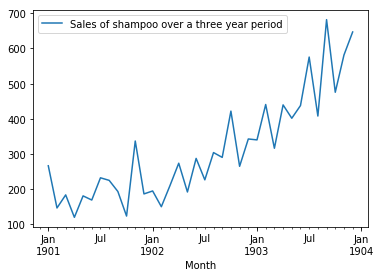

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

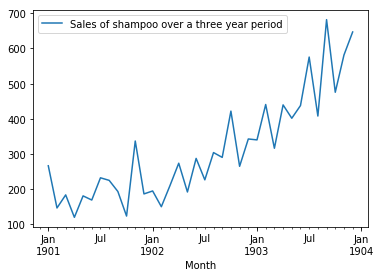

In [7]:
dataset.plot()
plt.rcParams['figure.figsize'] = (20,16)
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [8]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [9]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_random_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [10]:
x_train, x_test, y_train, y_test = make_timeseries_dataset_random_ordered(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [11]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


# Modeling 1. Prophet

In [12]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [13]:
from fbprophet import Prophet

### banila prediction (monthly)

In [14]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [15]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [17]:
forecast_data = m.predict(future_data)

In [18]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,581.871518,502.738195,660.951234
33,1903-10-01,491.845550,404.311732,573.082757
34,1903-11-01,540.990388,459.822446,620.239097
35,1903-12-01,569.817744,482.531051,644.072922
36,1903-12-31,500.759688,416.646964,584.037732


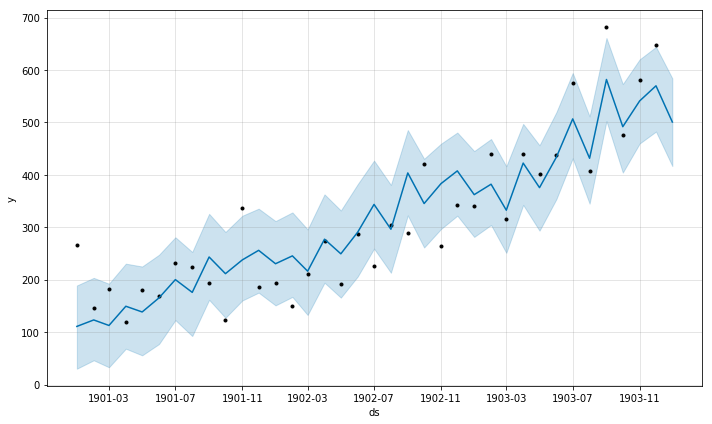

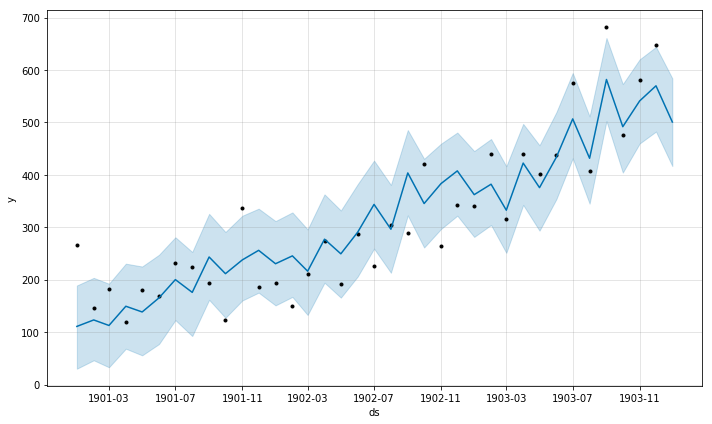

In [19]:
m.plot(forecast_data)

In [20]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1901-01-01,117.291396,30.203771,188.919180,117.291396,117.291396,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,0.0,0.0,0.0,110.876249
1,1901-02-01,128.037159,46.293031,203.459579,128.037159,128.037159,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,0.0,0.0,0.0,123.218289
2,1901-03-01,137.743009,32.961506,192.315984,137.743009,137.743009,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,0.0,0.0,0.0,112.697259
3,1901-04-01,148.488772,68.360272,230.560305,148.488772,148.488772,0.005806,0.005806,0.005806,0.005806,0.005806,0.005806,0.0,0.0,0.0,149.350918
4,1901-05-01,158.887897,55.696145,225.152985,158.887897,158.887897,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,0.0,0.0,0.0,138.434781


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [21]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,267.769417,564.410408
33,1903-10-01,396.816812,254.906024,552.904119
34,1903-11-01,400.333321,242.224824,558.368422
35,1903-12-01,422.099080,276.166023,582.510955
36,1903-12-31,380.605378,226.460518,537.307909


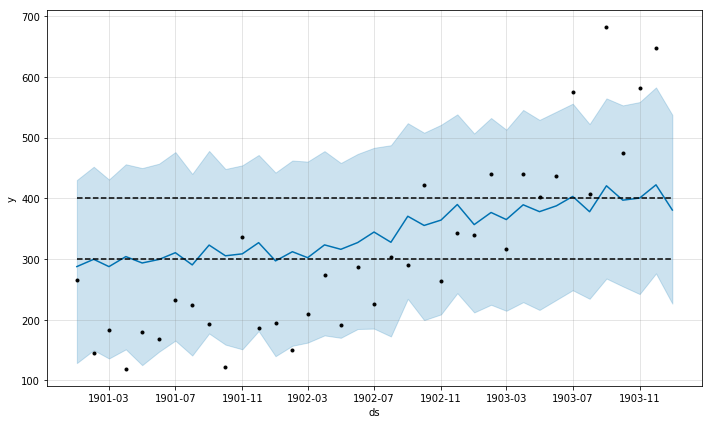

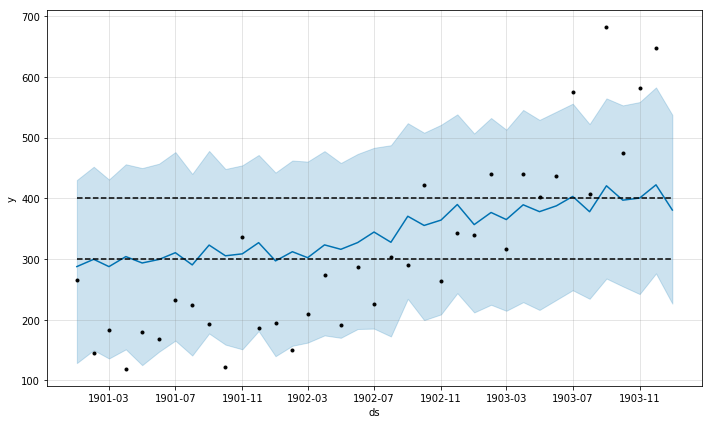

In [23]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [24]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [25]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.703761,408.977890,680.815242
33,1903-10-01,469.533135,342.772923,609.170804
34,1903-11-01,523.177099,376.222026,662.498823
35,1903-12-01,415.586594,280.295127,557.967549
36,1903-12-31,502.178388,359.360344,642.048390


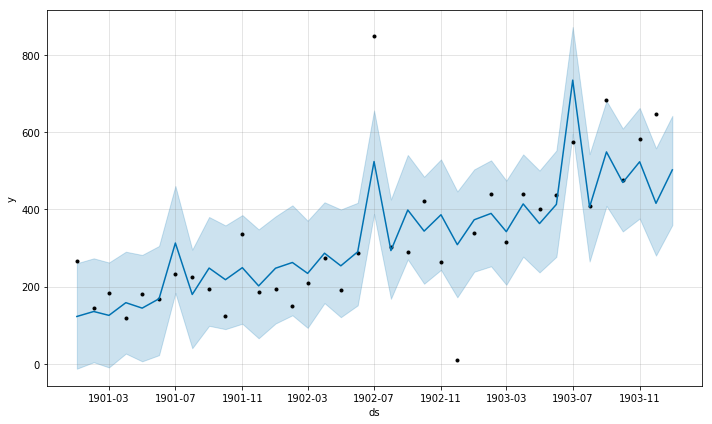

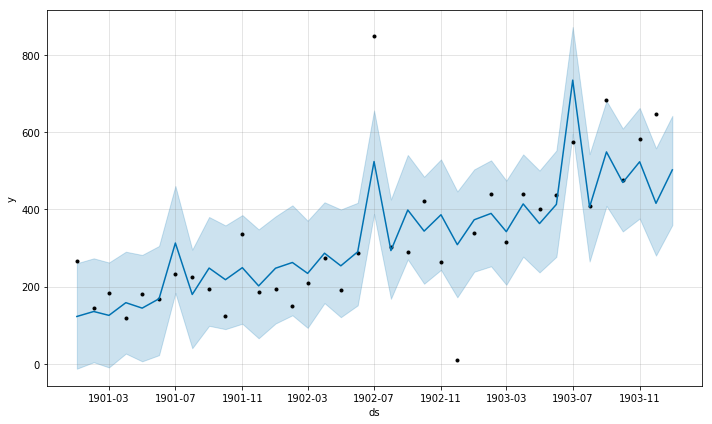

In [27]:
m.plot(forecast_data)

### rm outlier

In [28]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = None
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = None

In [29]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,575.752200,495.409009,649.687984
33,1903-10-01,488.268345,407.799718,567.447119
34,1903-11-01,535.208522,458.732997,615.737338
35,1903-12-01,602.970974,523.578773,672.450348
36,1903-12-31,484.517788,412.938972,564.532794


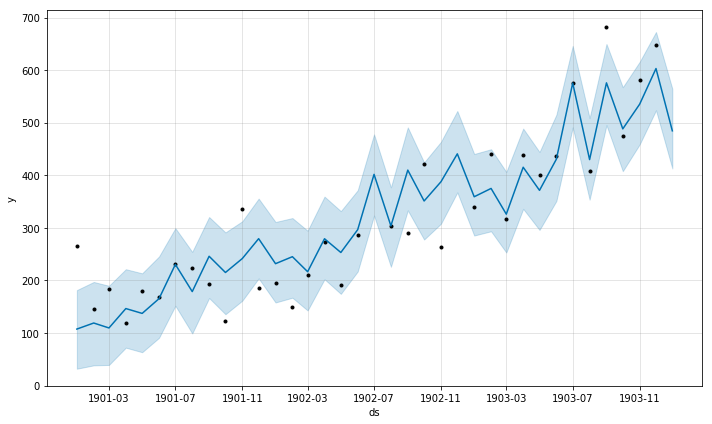

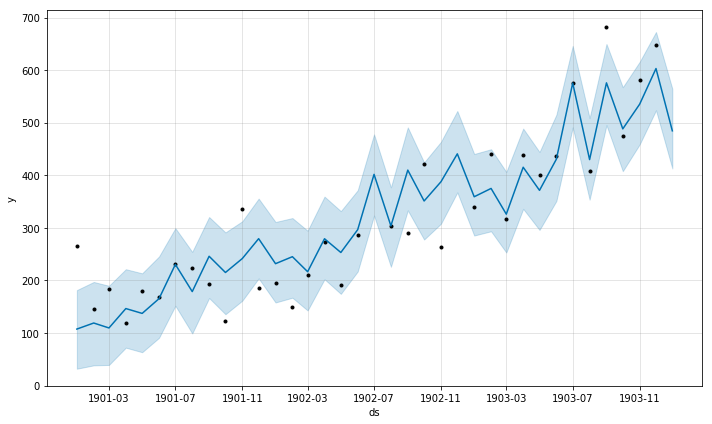

In [31]:
m.plot(forecast_data)

## Modeling 2. ARIMA(Autoregressive Integrated Moving Average)

- ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀 모형을 의미하고, Moving Average는 이동평균 모형을 의미한다.
- AR(Autoregression), 자기회귀 모형 : 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다. 큰 틀에서의 의미는 RNN과 완전히 동일하다. 다만, 선형적인 관계만을 정의하므로 정확하지는 않다.
- AR의 수식 : AR(1) -> Xt = theta * Xt-1 + et

- MA(Moving Average), 이동평균 모형 : 현재의 관측값이 이전의 관측 오차항에 영향을 받는다는 아이디어의 모형이다. 
- MA(1) -> Xt = et - B1 * et-1

- 이를 합한 ARMA 모형은 다음과 같다. 
- Xt=ϕXt−1+Wt+θWt−1
- 즉 정상성이 보장된다는 조건 하에 p차까지 자기회귀를 하고, 남은 잔차의 상관관계를 이용하여 오차항을 만들어내는 모형이다.
- ARIMA에서 I는 Integrated를 의미하는데, ARMA에서 시계열의 비정상성을 설명하기 위해 차분방정식의 개념을 도입하여 보정한 것을 의미하는 용어이다.

--------

- ARIMA의 하이퍼 파라미터는 3가지이다.
- (p, d , q)의 세 가지로, p와 q는 각각 AR, MA의 lag 개수를 의미하며 d는 차분의 횟수를 의미한다.

<img src="images/ARIMA.png">

### hyper parameter를 선정하는 방법
- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
- 두 그래프 중, 감소폭이나 증가폭이 완만한 그래프가 더 강한 영향을 미치는 것이라고 볼 수 있다.

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 
- 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

In [32]:
dataset = pd.read_csv(filename)
dataset.columns = ['Month', 'sale']
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
series = dataset

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


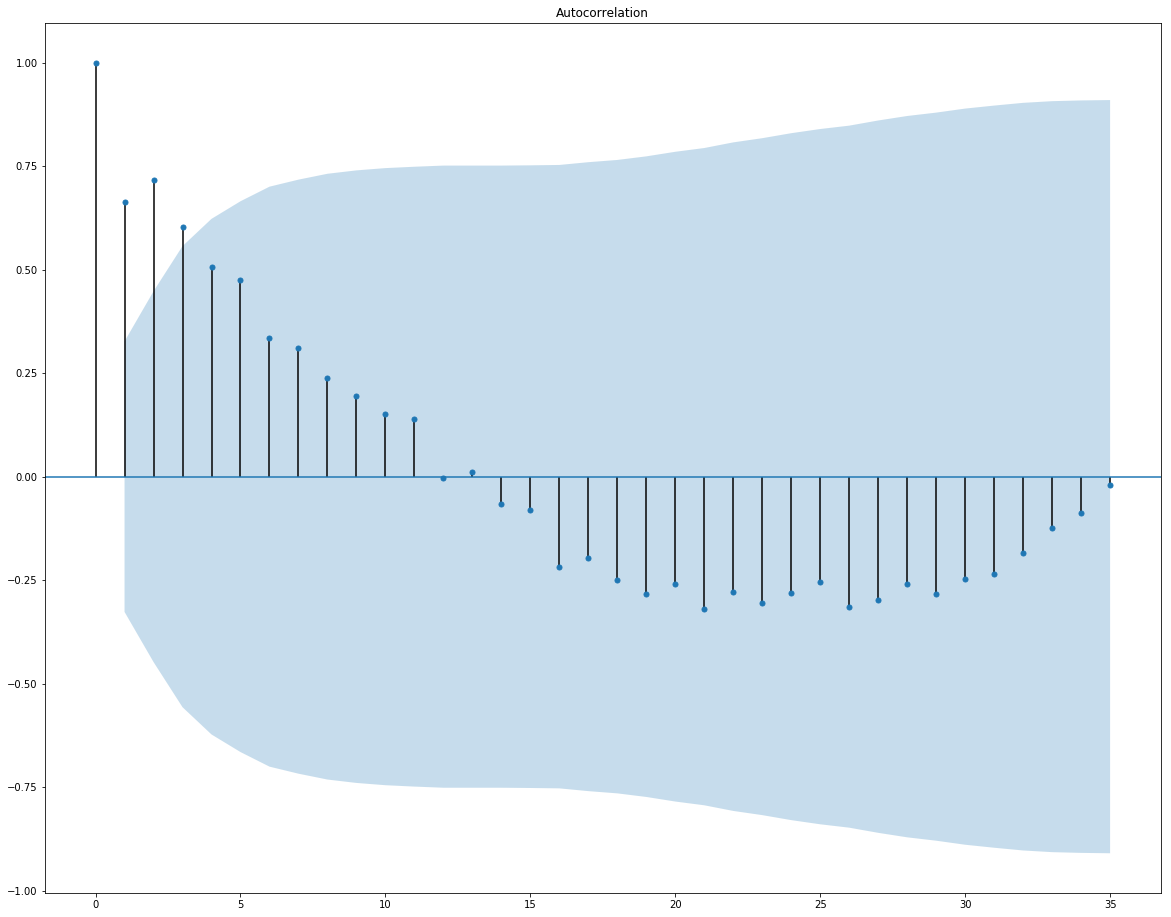

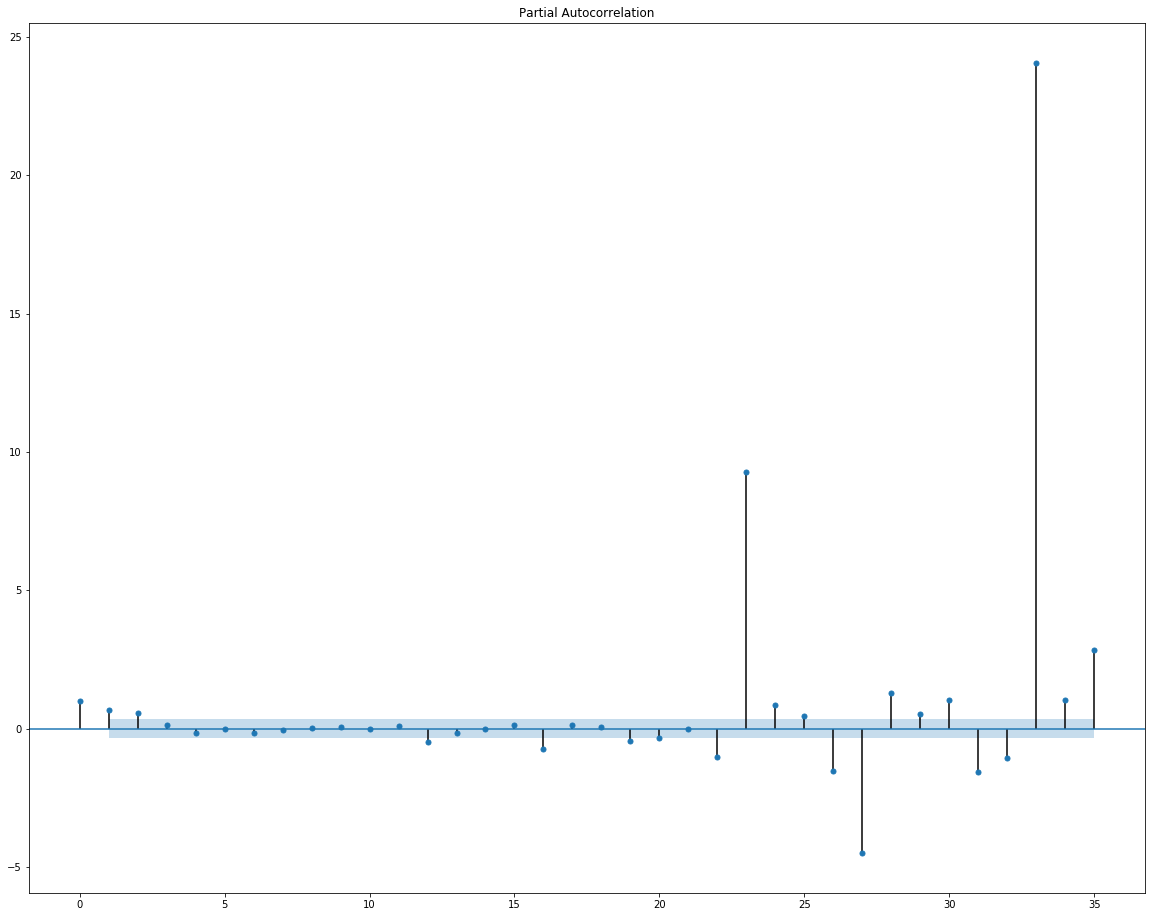

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

#### ARIMA 모델링

In [34]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(1,0,0)) # P>|z| -> 학습 계수에 대한 p-value 값으로, (a,b,c) 일때 가장 적절한 조합을 찾아야 한다.
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   sale   No. Observations:                   36
Model:                     ARMA(1, 0)   Log Likelihood                -218.079
Method:                       css-mle   S.D. of innovations            102.235
Date:                Tue, 28 Aug 2018   AIC                            442.157
Time:                        16:48:38   BIC                            446.908
Sample:                    01-01-1901   HQIC                           443.815
                         - 12-01-1903                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        333.2378     64.289      5.183      0.000     207.234     459.242
ar.L1.sale     0.7509      0.118      6.360      0.000       0.520       0.982
                                    Roots           

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = ou

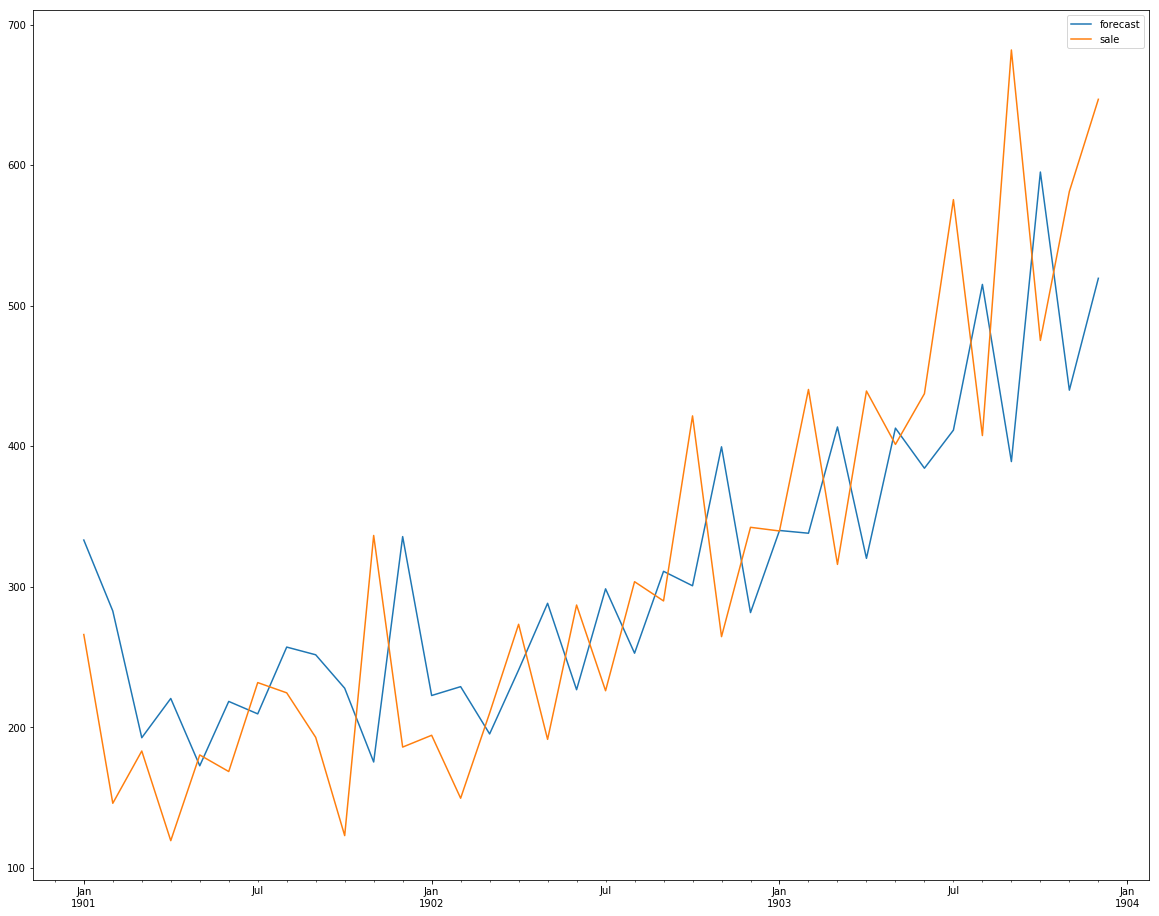

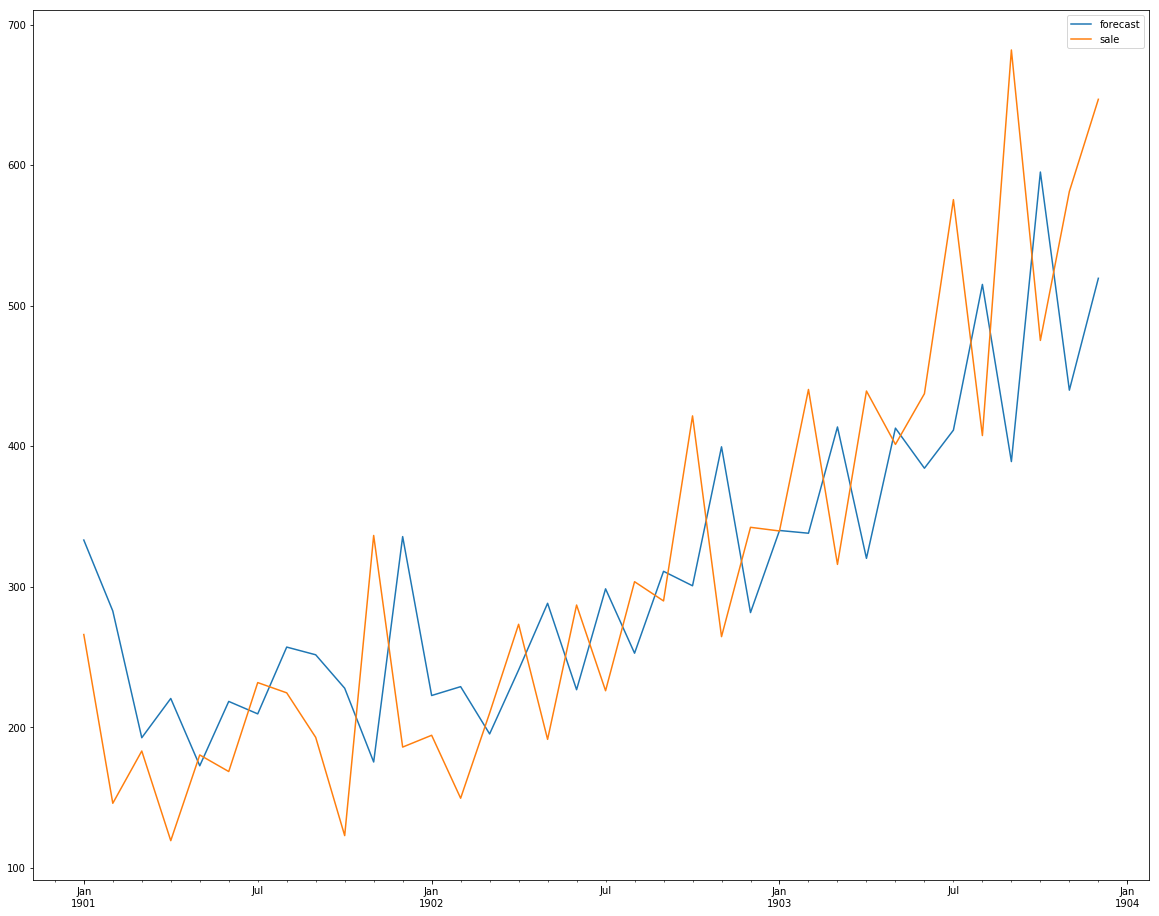

In [35]:
model_fit.plot_predict()

In [36]:
fore = model_fit.forecast(steps=3)
print(fore)

(array([568.7749614 , 510.10882218, 466.05488055]), array([102.23498718, 127.85057112, 140.24696386]), array([[368.39806856, 769.15185423],
       [259.52630739, 760.69133697],
       [191.17588244, 740.93387865]]))


## Modeling 3. LSTM
### 3-1) multi-to-one step

In [37]:
import os
import math
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### preprocessing for time-step prediction

In [148]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용하는 것이 좋음
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=1, y_steps=1, test_size=0.4)

- print shape

In [149]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [150]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (20, 1)
training Y data shape: (20, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [151]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [152]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (20, 1)
training Y data shape: (20, 1)
test X data shape: (12, 1)
test Y data shape: (12, 1)


- change shape for (LSTM or RNN)

In [153]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 1
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [154]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

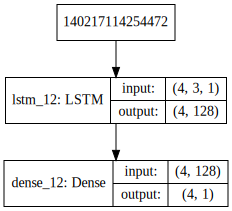

In [155]:
model = Sequential()
model.add(LSTM(128, batch_input_shape=(4, 3, 1), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

- return_sequences : many-to-many 문제나 lstm가 멀티 레이어인 경우 사용함. 각 time마다 y값을 출력 하느냐 마느냐의 결정.
- stateful : 상태유지모드 결정. 

#### stateful True

In [213]:
num_epochs = 500
batch_size=1

# simple lstm network learning
model = Sequential()
model.add(LSTM(128, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
20/20 [==============================] - 1s 58ms/step - loss: 0.1045
epochs : 1
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0853
epochs : 2
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0612
epochs : 3
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0477
epochs : 4
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0427
epochs : 5
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0418
epochs : 6
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0412
epochs : 7
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0400
epochs : 8
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0393
epochs : 9
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0385
epochs : 10
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0379
epochs : 11
Epoch 1

20/20 [==============================] - 0s 3ms/step - loss: 0.0139
epochs : 92
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0137
epochs : 93
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0135
epochs : 94
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0134
epochs : 95
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0132
epochs : 96
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0130
epochs : 97
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0129
epochs : 98
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0128
epochs : 99
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0126
epochs : 100
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0125
epochs : 101
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0125
epochs : 102
Epoch 1/1
20/20 [

20/20 [==============================] - 0s 2ms/step - loss: 0.0159
epochs : 182
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0158
epochs : 183
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0158
epochs : 184
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0156
epochs : 185
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0154
epochs : 186
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0153
epochs : 187
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0150
epochs : 188
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0150
epochs : 189
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0149
epochs : 190
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0149
epochs : 191
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0148
epochs : 192
Epoch 1/1

20/20 [==============================] - 0s 2ms/step - loss: 0.0138
epochs : 272
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0143
epochs : 273
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0167
epochs : 274
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0177
epochs : 275
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0137
epochs : 276
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0139
epochs : 277
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0146
epochs : 278
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0150
epochs : 279
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0155
epochs : 280
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0163
epochs : 281
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0142
epochs : 282
Epoch 1/1

20/20 [==============================] - 0s 3ms/step - loss: 0.0122
epochs : 362
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0146
epochs : 363
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0122
epochs : 364
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0147
epochs : 365
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0126
epochs : 366
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0147
epochs : 367
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0127
epochs : 368
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0144
epochs : 369
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0123
epochs : 370
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0138
epochs : 371
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0127
epochs : 372
Epoch 1/1

20/20 [==============================] - 0s 2ms/step - loss: 0.0096
epochs : 452
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0102
epochs : 453
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0103
epochs : 454
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0099
epochs : 455
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0097
epochs : 456
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0094
epochs : 457
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0093
epochs : 458
Epoch 1/1
20/20 [==============================] - 0s 3ms/step - loss: 0.0094
epochs : 459
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0093
epochs : 460
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0093
epochs : 461
Epoch 1/1
20/20 [==============================] - 0s 2ms/step - loss: 0.0092
epochs : 462
Epoch 1/1

In [214]:
# # plot for future
# y_pred = model.predict(x_test_series, batch_size=batch_size)
# y_pred_origin = scaler.inverse_transform(y_pred)
# y_test_origin = scaler.inverse_transform(y_test)
# test_score = math.sqrt(mean_squared_error(y_test_origin, y_pred_origin))
# print('Train Score: %.2f RMSE' % test_score)

# plt.plot(y_pred_origin)
# plt.plot(y_test_origin)
# plt.show()

# model.reset_states()

In [215]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i]
        predictions.append(yhat)
    model.reset_states()
    return predictions, origin_x_train

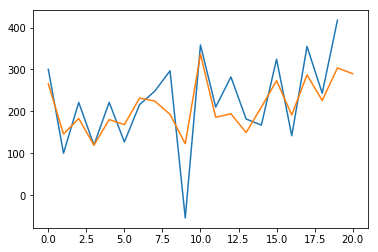

In [216]:
predictions, origin_x_train = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions)
plt.plot(origin_x_train)
plt.show()

In [217]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i]
        predictions.append(yhat)
    model.reset_states()
    return predictions, origin_x_test

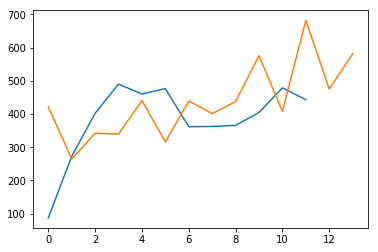

In [218]:
predictions, origin_x_test = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions)
plt.plot(origin_x_test)
plt.show()

#### stateful False

In [208]:
num_epochs = 1000
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, input_shape=(time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=False)) # shampoo data : data가 시계열순으로 증가하는 배치이기 때문에 stateful = False가 더 효율적
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_series, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=False)

# prediction
y_pred = model.predict(x_test_series, batch_size=1)
y_pred_origin = scaler.inverse_transform(y_pred)
y_test_origin = scaler.inverse_transform(y_test)
test_score = math.sqrt(mean_squared_error(y_test_origin, y_pred_origin))
print('Train Score: %.2f RMSE' % test_score)

Epoch 1/1000
27/27 [==============================] - 2s 89ms/step - loss: 0.0452
Epoch 2/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 5/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 6/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 7/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 8/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 9/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 10/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 11/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 12/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 13/1000
27/27 [===

Epoch 101/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 102/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 103/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 104/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 105/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 106/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 107/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 108/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 109/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 110/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 111/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 112/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0133
Epoc

27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 298/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 299/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 300/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 301/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 302/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 303/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 304/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 305/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 306/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 307/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 308/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 309/1000
27/2

27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 494/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 495/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 496/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 497/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 498/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 499/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 500/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 501/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 502/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 503/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 504/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 505/1000
27/2

27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 690/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 691/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 692/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 693/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 694/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 695/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 696/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 697/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 698/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 699/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 700/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 701/1000
27/2

27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 886/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 887/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 888/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 889/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 890/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 891/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 892/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 893/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 894/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 895/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 896/1000
27/27 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 897/1000
27/2

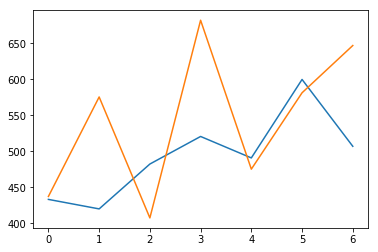

In [209]:
# plot for future
plt.plot(y_pred_origin)
plt.plot(y_test_origin)
plt.show()

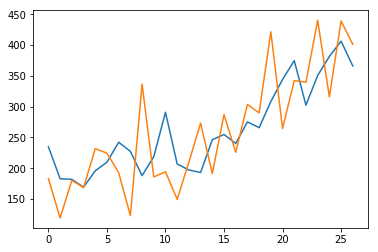

In [210]:
y_pred = model.predict(x_train_series, batch_size=batch_size)
y_pred_origin = scaler.inverse_transform(y_pred)
y_train_origin = scaler.inverse_transform(y_train)

# plot for fast
plt.plot(y_pred_origin)
plt.plot(y_train_origin)
plt.show()

### 3-1) multi-to-multi step

## Modeling 4. bitcoin data with LSTM

https://www.blockchain.com/ko/charts/market-price?timespan=60days